In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super(BasicConv2d, self).__init__()
        self.relu = relu
        if self.relu:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        return out

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                        relu=True, kernel_size=3, stride=stride, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels,
                        relu=False, kernel_size=3, stride=1, padding=1, bias=False),
        )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if self.downsample is None:
            residual = x
        else:
            residual = self.downsample(x)
        out = self.features(x)
        out += residual
        out = F.relu(out, inplace=True)

        return out

In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.features = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                        relu=True, kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels,
                        relu=True, kernel_size=3, stride=stride, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels, out_channels=out_channels *
                        self.expansion, relu=False, kernel_size=1, stride=1, padding=0, bias=False),
        )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        if self.downsample is None:
            residual = x
        else:
            residual = self.downsample(x)
        out = self.features(x)
        out += residual
        out = F.relu(out, inplace=True)

        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=64, relu=True,
                        kernel_size=7, stride=2, padding=3, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = self._make_layer(
            block=block, out_channels=64, num_blocks=layers[0], stride=1)
        self.layer2 = self._make_layer(
            block=block, out_channels=128, num_blocks=layers[1], stride=2)
        self.layer3 = self._make_layer(
            block=block, out_channels=256, num_blocks=layers[2], stride=2)
        self.layer4 = self._make_layer(
            block=block, out_channels=512, num_blocks=layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = BasicConv2d(in_channels=self.in_channels, out_channels=out_channels * block.expansion, relu=False,
                                     kernel_size=1, stride=stride, bias=False)
        layers = []
        layers.append(block(in_channels=self.in_channels,
                            out_channels=out_channels, stride=stride, downsample=downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(in_channels=self.in_channels,
                                out_channels=out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [11]:
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [12]:
net = resnet50().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
       BasicConv2d-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 256, 56, 56]          16,384
       BatchNorm2d-7          [-1, 256, 56, 56]             512
       BasicConv2d-8          [-1, 256, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
      BasicConv2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [15]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [16]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [17]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [18]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [19]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [20]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.368633
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.026208
Train Epoch: 1 [12800/40000 (32%)]	Loss: 2.046514
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.732678
Train Epoch: 1 [25600/40000 (64%)]	Loss: 2.007777
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.797680
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.631787
VAL set: Average loss: 0.023715, Accuracy: 4374.0/10000 (43.7%)
Validation loss decreased (inf --> 0.023715).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.490514
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.756299
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.607874
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.529342
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.417133
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.475542
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.413797
VAL set: Average loss: 0.021516, Accuracy: 4936.0/10000 (49.4%)
Validation loss decreased (0.023715 --> 0.021516).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.527942
Trai

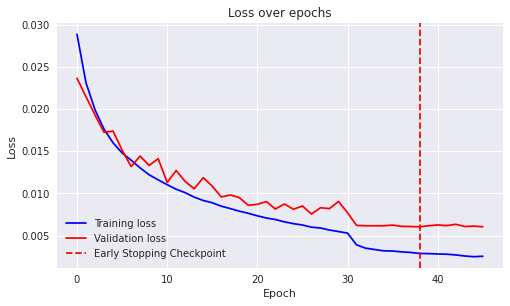

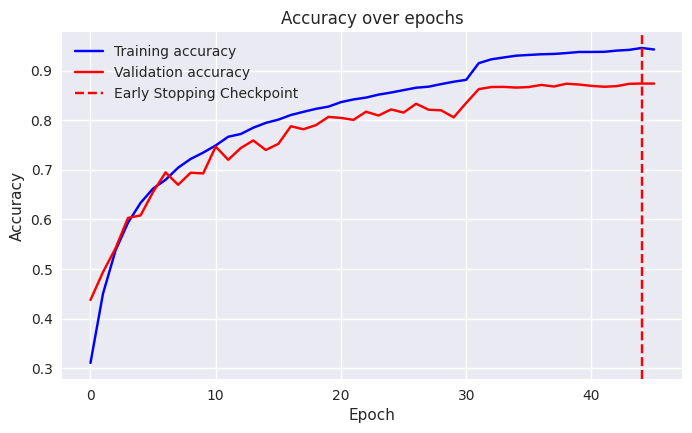

In [21]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'ResNet - predictions')

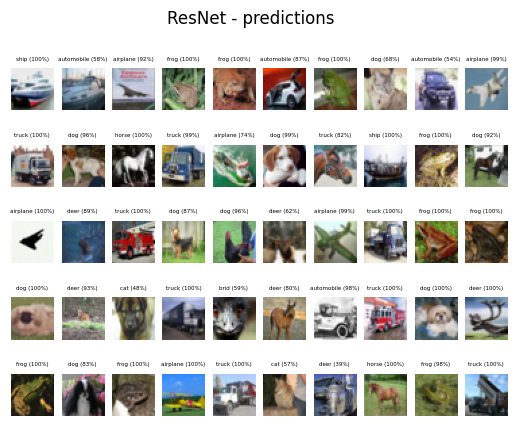

In [22]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('ResNet - predictions')

In [ ]:
"""
ResNet-50
Mine(batch_size = 32):
After 020 Epoch: 84.2%
After 040 Epoch: 89.2%
After 041 Epoch: 89.0%
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
       BasicConv2d-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 256, 56, 56]          16,384
       BatchNorm2d-7          [-1, 256, 56, 56]             512
       BasicConv2d-8          [-1, 256, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
      BasicConv2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64, 56, 56]             128
             ReLU-15           [-1, 64, 56, 56]               0
      BasicConv2d-16           [-1, 64, 56, 56]               0
           Conv2d-17          [-1, 256, 56, 56]          16,384
      BatchNorm2d-18          [-1, 256, 56, 56]             512
      BasicConv2d-19          [-1, 256, 56, 56]               0
       Bottleneck-20          [-1, 256, 56, 56]               0
           Conv2d-21           [-1, 64, 56, 56]          16,384
      BatchNorm2d-22           [-1, 64, 56, 56]             128
             ReLU-23           [-1, 64, 56, 56]               0
      BasicConv2d-24           [-1, 64, 56, 56]               0
           Conv2d-25           [-1, 64, 56, 56]          36,864
      BatchNorm2d-26           [-1, 64, 56, 56]             128
             ReLU-27           [-1, 64, 56, 56]               0
      BasicConv2d-28           [-1, 64, 56, 56]               0
           Conv2d-29          [-1, 256, 56, 56]          16,384
      BatchNorm2d-30          [-1, 256, 56, 56]             512
      BasicConv2d-31          [-1, 256, 56, 56]               0
       Bottleneck-32          [-1, 256, 56, 56]               0
           Conv2d-33           [-1, 64, 56, 56]          16,384
      BatchNorm2d-34           [-1, 64, 56, 56]             128
             ReLU-35           [-1, 64, 56, 56]               0
      BasicConv2d-36           [-1, 64, 56, 56]               0
           Conv2d-37           [-1, 64, 56, 56]          36,864
      BatchNorm2d-38           [-1, 64, 56, 56]             128
             ReLU-39           [-1, 64, 56, 56]               0
      BasicConv2d-40           [-1, 64, 56, 56]               0
           Conv2d-41          [-1, 256, 56, 56]          16,384
      BatchNorm2d-42          [-1, 256, 56, 56]             512
      BasicConv2d-43          [-1, 256, 56, 56]               0
       Bottleneck-44          [-1, 256, 56, 56]               0
           Conv2d-45          [-1, 512, 28, 28]         131,072
      BatchNorm2d-46          [-1, 512, 28, 28]           1,024
      BasicConv2d-47          [-1, 512, 28, 28]               0
           Conv2d-48          [-1, 128, 56, 56]          32,768
      BatchNorm2d-49          [-1, 128, 56, 56]             256
             ReLU-50          [-1, 128, 56, 56]               0
      BasicConv2d-51          [-1, 128, 56, 56]               0
           Conv2d-52          [-1, 128, 28, 28]         147,456
      BatchNorm2d-53          [-1, 128, 28, 28]             256
             ReLU-54          [-1, 128, 28, 28]               0
      BasicConv2d-55          [-1, 128, 28, 28]               0
           Conv2d-56          [-1, 512, 28, 28]          65,536
      BatchNorm2d-57          [-1, 512, 28, 28]           1,024
      BasicConv2d-58          [-1, 512, 28, 28]               0
       Bottleneck-59          [-1, 512, 28, 28]               0
           Conv2d-60          [-1, 128, 28, 28]          65,536
      BatchNorm2d-61          [-1, 128, 28, 28]             256
             ReLU-62          [-1, 128, 28, 28]               0
      BasicConv2d-63          [-1, 128, 28, 28]               0
           Conv2d-64          [-1, 128, 28, 28]         147,456
      BatchNorm2d-65          [-1, 128, 28, 28]             256
             ReLU-66          [-1, 128, 28, 28]               0
      BasicConv2d-67          [-1, 128, 28, 28]               0
           Conv2d-68          [-1, 512, 28, 28]          65,536
      BatchNorm2d-69          [-1, 512, 28, 28]           1,024
      BasicConv2d-70          [-1, 512, 28, 28]               0
       Bottleneck-71          [-1, 512, 28, 28]               0
           Conv2d-72          [-1, 128, 28, 28]          65,536
      BatchNorm2d-73          [-1, 128, 28, 28]             256
             ReLU-74          [-1, 128, 28, 28]               0
      BasicConv2d-75          [-1, 128, 28, 28]               0
           Conv2d-76          [-1, 128, 28, 28]         147,456
      BatchNorm2d-77          [-1, 128, 28, 28]             256
             ReLU-78          [-1, 128, 28, 28]               0
      BasicConv2d-79          [-1, 128, 28, 28]               0
           Conv2d-80          [-1, 512, 28, 28]          65,536
      BatchNorm2d-81          [-1, 512, 28, 28]           1,024
      BasicConv2d-82          [-1, 512, 28, 28]               0
       Bottleneck-83          [-1, 512, 28, 28]               0
           Conv2d-84          [-1, 128, 28, 28]          65,536
      BatchNorm2d-85          [-1, 128, 28, 28]             256
             ReLU-86          [-1, 128, 28, 28]               0
      BasicConv2d-87          [-1, 128, 28, 28]               0
           Conv2d-88          [-1, 128, 28, 28]         147,456
      BatchNorm2d-89          [-1, 128, 28, 28]             256
             ReLU-90          [-1, 128, 28, 28]               0
      BasicConv2d-91          [-1, 128, 28, 28]               0
           Conv2d-92          [-1, 512, 28, 28]          65,536
      BatchNorm2d-93          [-1, 512, 28, 28]           1,024
      BasicConv2d-94          [-1, 512, 28, 28]               0
       Bottleneck-95          [-1, 512, 28, 28]               0
           Conv2d-96         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-97         [-1, 1024, 14, 14]           2,048
      BasicConv2d-98         [-1, 1024, 14, 14]               0
           Conv2d-99          [-1, 256, 28, 28]         131,072
     BatchNorm2d-100          [-1, 256, 28, 28]             512
            ReLU-101          [-1, 256, 28, 28]               0
     BasicConv2d-102          [-1, 256, 28, 28]               0
          Conv2d-103          [-1, 256, 14, 14]         589,824
     BatchNorm2d-104          [-1, 256, 14, 14]             512
            ReLU-105          [-1, 256, 14, 14]               0
     BasicConv2d-106          [-1, 256, 14, 14]               0
          Conv2d-107         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-108         [-1, 1024, 14, 14]           2,048
     BasicConv2d-109         [-1, 1024, 14, 14]               0
      Bottleneck-110         [-1, 1024, 14, 14]               0
          Conv2d-111          [-1, 256, 14, 14]         262,144
     BatchNorm2d-112          [-1, 256, 14, 14]             512
            ReLU-113          [-1, 256, 14, 14]               0
     BasicConv2d-114          [-1, 256, 14, 14]               0
          Conv2d-115          [-1, 256, 14, 14]         589,824
     BatchNorm2d-116          [-1, 256, 14, 14]             512
            ReLU-117          [-1, 256, 14, 14]               0
     BasicConv2d-118          [-1, 256, 14, 14]               0
          Conv2d-119         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-120         [-1, 1024, 14, 14]           2,048
     BasicConv2d-121         [-1, 1024, 14, 14]               0
      Bottleneck-122         [-1, 1024, 14, 14]               0
          Conv2d-123          [-1, 256, 14, 14]         262,144
     BatchNorm2d-124          [-1, 256, 14, 14]             512
            ReLU-125          [-1, 256, 14, 14]               0
     BasicConv2d-126          [-1, 256, 14, 14]               0
          Conv2d-127          [-1, 256, 14, 14]         589,824
     BatchNorm2d-128          [-1, 256, 14, 14]             512
            ReLU-129          [-1, 256, 14, 14]               0
     BasicConv2d-130          [-1, 256, 14, 14]               0
          Conv2d-131         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-132         [-1, 1024, 14, 14]           2,048
     BasicConv2d-133         [-1, 1024, 14, 14]               0
      Bottleneck-134         [-1, 1024, 14, 14]               0
          Conv2d-135          [-1, 256, 14, 14]         262,144
     BatchNorm2d-136          [-1, 256, 14, 14]             512
            ReLU-137          [-1, 256, 14, 14]               0
     BasicConv2d-138          [-1, 256, 14, 14]               0
          Conv2d-139          [-1, 256, 14, 14]         589,824
     BatchNorm2d-140          [-1, 256, 14, 14]             512
            ReLU-141          [-1, 256, 14, 14]               0
     BasicConv2d-142          [-1, 256, 14, 14]               0
          Conv2d-143         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-144         [-1, 1024, 14, 14]           2,048
     BasicConv2d-145         [-1, 1024, 14, 14]               0
      Bottleneck-146         [-1, 1024, 14, 14]               0
          Conv2d-147          [-1, 256, 14, 14]         262,144
     BatchNorm2d-148          [-1, 256, 14, 14]             512
            ReLU-149          [-1, 256, 14, 14]               0
     BasicConv2d-150          [-1, 256, 14, 14]               0
          Conv2d-151          [-1, 256, 14, 14]         589,824
     BatchNorm2d-152          [-1, 256, 14, 14]             512
            ReLU-153          [-1, 256, 14, 14]               0
     BasicConv2d-154          [-1, 256, 14, 14]               0
          Conv2d-155         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-156         [-1, 1024, 14, 14]           2,048
     BasicConv2d-157         [-1, 1024, 14, 14]               0
      Bottleneck-158         [-1, 1024, 14, 14]               0
          Conv2d-159          [-1, 256, 14, 14]         262,144
     BatchNorm2d-160          [-1, 256, 14, 14]             512
            ReLU-161          [-1, 256, 14, 14]               0
     BasicConv2d-162          [-1, 256, 14, 14]               0
          Conv2d-163          [-1, 256, 14, 14]         589,824
     BatchNorm2d-164          [-1, 256, 14, 14]             512
            ReLU-165          [-1, 256, 14, 14]               0
     BasicConv2d-166          [-1, 256, 14, 14]               0
          Conv2d-167         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-168         [-1, 1024, 14, 14]           2,048
     BasicConv2d-169         [-1, 1024, 14, 14]               0
      Bottleneck-170         [-1, 1024, 14, 14]               0
          Conv2d-171           [-1, 2048, 7, 7]       2,097,152
     BatchNorm2d-172           [-1, 2048, 7, 7]           4,096
     BasicConv2d-173           [-1, 2048, 7, 7]               0
          Conv2d-174          [-1, 512, 14, 14]         524,288
     BatchNorm2d-175          [-1, 512, 14, 14]           1,024
            ReLU-176          [-1, 512, 14, 14]               0
     BasicConv2d-177          [-1, 512, 14, 14]               0
          Conv2d-178            [-1, 512, 7, 7]       2,359,296
     BatchNorm2d-179            [-1, 512, 7, 7]           1,024
            ReLU-180            [-1, 512, 7, 7]               0
     BasicConv2d-181            [-1, 512, 7, 7]               0
          Conv2d-182           [-1, 2048, 7, 7]       1,048,576
     BatchNorm2d-183           [-1, 2048, 7, 7]           4,096
     BasicConv2d-184           [-1, 2048, 7, 7]               0
      Bottleneck-185           [-1, 2048, 7, 7]               0
          Conv2d-186            [-1, 512, 7, 7]       1,048,576
     BatchNorm2d-187            [-1, 512, 7, 7]           1,024
            ReLU-188            [-1, 512, 7, 7]               0
     BasicConv2d-189            [-1, 512, 7, 7]               0
          Conv2d-190            [-1, 512, 7, 7]       2,359,296
     BatchNorm2d-191            [-1, 512, 7, 7]           1,024
            ReLU-192            [-1, 512, 7, 7]               0
     BasicConv2d-193            [-1, 512, 7, 7]               0
          Conv2d-194           [-1, 2048, 7, 7]       1,048,576
     BatchNorm2d-195           [-1, 2048, 7, 7]           4,096
     BasicConv2d-196           [-1, 2048, 7, 7]               0
      Bottleneck-197           [-1, 2048, 7, 7]               0
          Conv2d-198            [-1, 512, 7, 7]       1,048,576
     BatchNorm2d-199            [-1, 512, 7, 7]           1,024
            ReLU-200            [-1, 512, 7, 7]               0
     BasicConv2d-201            [-1, 512, 7, 7]               0
          Conv2d-202            [-1, 512, 7, 7]       2,359,296
     BatchNorm2d-203            [-1, 512, 7, 7]           1,024
            ReLU-204            [-1, 512, 7, 7]               0
     BasicConv2d-205            [-1, 512, 7, 7]               0
          Conv2d-206           [-1, 2048, 7, 7]       1,048,576
     BatchNorm2d-207           [-1, 2048, 7, 7]           4,096
     BasicConv2d-208           [-1, 2048, 7, 7]               0
      Bottleneck-209           [-1, 2048, 7, 7]               0
AdaptiveAvgPool2d-210           [-1, 2048, 1, 1]               0
          Linear-211                   [-1, 10]          20,490
================================================================
Total params: 23,528,522
Trainable params: 23,528,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 329.23
Params size (MB): 89.75
Estimated Total Size (MB): 419.56
----------------------------------------------------------------
parameters_count: 23528522
Pytorch(batch_size = 32):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
Pytorch(batch_size = 64):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
ResNet-50
Pytorch(batch_size = 32):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
"""